# Part I - Exploring the Propser Loan Dataset
## by Charles Nikoro

## Introduction

In this document, I will analyze loan data from Prosper (a peear-to-peer lending marketplace) comprising approximately 114000 records with the aim of investigating the possible factors that can affect the outcome of a loan's status.

## Preliminary Wrangling


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math

%matplotlib inline

In [2]:
# load data and check the first five records
# make sure the dates are correctly parsed

loans = pd.read_csv('../dataset/prosperLoanData.csv', parse_dates=['ListingCreationDate',
    'LoanOriginationDate', 'ClosedDate', 'DateCreditPulled'])

loans.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263,C,36,Completed,2009-08-14,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900,NaN,36,Current,NaT,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090,HR,36,Completed,2009-12-17,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010,NaN,36,Current,NaT,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097,NaN,36,Current,NaT,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [3]:
# check the size of the dataset and whether it contains duplicate listings.

print("Shape of the dataframe:", loans.shape)
print("Number of duplicate records:", loans.duplicated().sum())

Shape of the dataframe: (113937, 81)
Number of duplicate records: 0


In [4]:
# columns and their data types

dtypes = ['bool', 'int64', 'float64', 'object']

for dtype in dtypes:
    print(f"{dtype}\n{set(loans.dtypes[loans.dtypes == dtype].index)}\n")

bool
{'CurrentlyInGroup', 'IncomeVerifiable', 'IsBorrowerHomeowner'}

int64
{'LoanCurrentDaysDelinquent', 'OpenRevolvingAccounts', 'LoanOriginalAmount', 'Investors', 'ListingNumber', 'LoanNumber', 'Term', 'ListingCategory (numeric)', 'LoanMonthsSinceOrigination', 'Recommendations', 'InvestmentFromFriendsCount'}

float64
{'ProsperPrincipalBorrowed', 'MonthlyLoanPayment', 'LP_CustomerPayments', 'EstimatedEffectiveYield', 'TotalCreditLinespast7years', 'BankcardUtilization', 'ScorexChangeAtTimeOfListing', 'LP_GrossPrincipalLoss', 'BorrowerAPR', 'ProsperRating (numeric)', 'PublicRecordsLast12Months', 'LP_CustomerPrincipalPayments', 'InquiriesLast6Months', 'EmploymentStatusDuration', 'DebtToIncomeRatio', 'EstimatedLoss', 'EstimatedReturn', 'OpenCreditLines', 'AmountDelinquent', 'LoanFirstDefaultedCycleNumber', 'LP_InterestandFees', 'BorrowerRate', 'ProsperPrincipalOutstanding', 'TradesNeverDelinquent (percentage)', 'ProsperScore', 'TotalProsperPaymentsBilled', 'ProsperPaymentsLessThanOneMont

In [5]:
# make ListingCategory (numeric), ProsperScore and Term of categorical types

def create_category_type(categories, ordered=False):
    """
        Create category type from the list of categories

        Args:
           list: the list of categories
           bool: whether the category type should be ordered. This is False by default

        Returns:
           a pandas CategoricalDtype object.
    """
    return pd.api.types.CategoricalDtype(categories=categories, ordered=ordered)

loans['ListingCategory (numeric)'] = loans['ListingCategory (numeric)'].astype(
    create_category_type(range(21))
)

loans.Term = loans.Term.astype(create_category_type([12,36,60], ordered=True))

# ProsperScore is an ordinal variable

loans.ProsperScore = loans.ProsperScore.astype(create_category_type(categories=range(1,12), ordered=True))

In [6]:
# value counts of IncomeRange

print('Value counts of IncomeRange: \n',loans.IncomeRange.value_counts(dropna=False))
print()
print('Value counts of EmploymentStatus: \n', loans.EmploymentStatus.value_counts(dropna=False))

Value counts of IncomeRange: 
 $25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
Not employed        806
$0                  621
Name: IncomeRange, dtype: int64

Value counts of EmploymentStatus: 
 Employed         67322
Full-time        26355
Self-employed     6134
Not available     5347
Other             3806
NaN               2255
Part-time         1088
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64


There are about 2255 records with a missing Employment status. Let's explore their Income ranges and compare them with those of borrowers with a "Not available" employment status.

In [7]:
# Income range of borrowers with missing employment status

print('Income range of borrowers with missing employment status\n',
    loans[loans.EmploymentStatus.isna()][["IncomeRange"]].value_counts()
)

print()

# Income range of borrowers with a "Not available" employment status
print('Income range of borrowers with a "Not available" employment status',
      loans[loans.EmploymentStatus == "Not available"][['IncomeRange']].value_counts()
)

Income range of borrowers with missing employment status
 IncomeRange  
Not displayed    2255
dtype: int64

Income range of borrowers with a "Not available" employment status IncomeRange  
Not displayed    5347
dtype: int64


Both have a "Not displayed" income range. Therefore, we can safely assume that these missing records don't have available employment status. So, we would replace them with "Not available".

In [8]:
# replacing missing Employment status records with "Not available"

loans.EmploymentStatus.fillna("Not available", inplace=True)

loans.EmploymentStatus.value_counts(dropna=False)

Employed         67322
Full-time        26355
Not available     7602
Self-employed     6134
Other             3806
Part-time         1088
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

We will also merge the records of borrowers with a "Full-time" and "Part-time" employment status to those with an "Employed" status since we can assume that people with a full-time or part-time job are employed by some employer.

In [9]:
values_to_replace = ['Full-time', 'Part-time']
for value in values_to_replace:
    loans.EmploymentStatus.replace(value, "Employed", inplace=True)

loans.EmploymentStatus.value_counts()

Employed         94765
Not available     7602
Self-employed     6134
Other             3806
Not employed       835
Retired            795
Name: EmploymentStatus, dtype: int64

We will focus on records that have "Not Employed', "Employed", "Self-employed", and "Retired" statuses.

In [10]:
exclusion_list = ['Other', 'Not available']
loans = loans.query('EmploymentStatus not in @exclusion_list')

loans.shape

(102529, 81)

It is also not logical to have "Not employed" in the possible income range. Let's do a value count of their stated monthly income.

In [11]:
loans[loans.IncomeRange == "Not employed"].StatedMonthlyIncome.value_counts(dropna=False)

0.000000        726
0.083333         22
583.333333        2
833.333333        2
1000.000000       2
1250.000000       1
4000.000000       1
964.333333        1
839.666667        1
393.416667        1
860.000000        1
1400.000000       1
1500.000000       1
480.000000        1
20833.333333      1
2348.000000       1
57.583333         1
669.000000        1
1507.000000       1
430.000000        1
738.166667        1
6666.666667       1
875.000000        1
1916.666667       1
9096.000000       1
1173.000000       1
3000.000000       1
4166.666667       1
1409.250000       1
2972.000000       1
643.000000        1
5833.333333       1
1014.000000       1
856.000000        1
1211.666667       1
623.000000        1
2926.000000       1
1505.000000       1
175.000000        1
3500.000000       1
3633.000000       1
2167.583333       1
125.250000        1
1820.000000       1
1360.000000       1
2025.000000       1
828.000000        1
37.500000         1
3333.333333       1
2775.916667       1


From the counts, we can't assume that the true income range value of every borrower with a "Not employed" income range will be $0. Since the income range isn't displayed, it will be safe to merge these records with those whose income range isn't displayed.

In [12]:
loans.IncomeRange.replace("Not employed", "Not displayed", inplace=True)

loans.IncomeRange.value_counts(dropna=False)

$25,000-49,999    30577
$50,000-74,999    30169
$100,000+         17209
$75,000-99,999    16681
$1-24,999          6327
Not displayed       945
$0                  621
Name: IncomeRange, dtype: int64

Let's make `IncomeRange` and `EmploymentStatus` categorical variables.

In [13]:
# IncomeRange should be categorical

categories = ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999',
               '$75,000-99,999', '$100,000+', 'Not displayed']

loans.IncomeRange = loans.IncomeRange.astype(create_category_type(categories=categories, ordered=True))

# EmploymentStatus should also be categorical

categories = ['Not employed', 'Self-employed', 'Employed', 'Retired']
loans.EmploymentStatus = loans.EmploymentStatus.astype(create_category_type(categories=categories))

It also makes sense to make `LoanStatus` a categorical variable.

In [14]:
# check values of LoanStatus

loans.LoanStatus.value_counts()

Current                   53694
Completed                 33109
Chargedoff                10341
Defaulted                  3238
Past Due (1-15 days)        760
Past Due (31-60 days)       335
Past Due (61-90 days)       300
Past Due (91-120 days)      286
Past Due (16-30 days)       252
FinalPaymentInProgress      197
Past Due (>120 days)         16
Cancelled                     1
Name: LoanStatus, dtype: int64

However, I will only be analyzing loans that have been closed. Therefore, we will only consider loans that are either complete, have been defaulted, or charged-off.

In [85]:
# We won't consider current and cancelled loans in our analysis.

excluded_list = ['Current', 'Cancelled', 'FinalPaymentInProgress',
 'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 
'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)', ]

loan_sub_data = loans.query('LoanStatus not in @excluded_list').copy()

# the loan status should be categorical. We will also make it ordinal

categories = ['Completed', 'Defaulted', 'Chargedoff']
loan_sub_data.LoanStatus = loan_sub_data.LoanStatus.astype(create_category_type(categories=categories, ordered=True))

# The shape of the subset of data we will be analyzing

print(loan_sub_data.shape)

(46688, 81)


In [16]:
# columns without null values

columns_without_null = loan_sub_data.isna().sum()==0
loan_sub_data.isna().sum()[columns_without_null].index

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'Term',
       'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'ListingCategory (numeric)', 'Occupation',
       'EmploymentStatus', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
       'TotalInquiries', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanKey', 'LoanCurrentDaysDelinquent',
       'LoanMonthsSinceOrigination', 'LoanNumber', 'LoanOriginalAmount',
       'LoanOriginationDate', 'LoanOriginationQuarter', 'MemberKey',
       'MonthlyLoanPayment', 'LP_CustomerPayments',
       'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees',
       'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations',
       'InvestmentFromFriendsCoun

In [17]:
# columns with null values

columns_with_null = loan_sub_data.isna().sum()>0
loan_sub_data.isna().sum()[columns_with_null].index

Index(['CreditGrade', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'BorrowerState', 'EmploymentStatusDuration', 'GroupKey',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'InquiriesLast6Months',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'TotalProsperLoans', 'TotalProsperPaymentsBilled',
       'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate',
       'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed',
       'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing',
       'LoanFirstDefaultedCycleN

### What is the structure of your dataset?
The dataset comprises 113937 observations and 81 variables which comprises both qualitative and quantitative variables. Some of them contain null values which means that there are no existing records for the borrower concerned. For instance, according to the [data dictionary](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0), a borrower with a null `TotalProsperLoans` value doesn't have prior loans. The categorical variables includes `ListingCategory (numeric)`, `LoanStatus`, `IncomeRange`, `ProsperScore`, and `Term`. `ListingCategory (numeric)` is encoded as follows: 0 - Not Available, 1 - Debt Consolidation, 2 - Home 
Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic 
Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - 
Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans. `ProsperScore` include values from 1 to 11 with decreasing levels of risk.

### What is/are the main feature(s) of interest in your dataset?

I want to investigate the factors that could affect the outcome of a loan. In particular, I will be considering those that affect complete, default and charged-off loans.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

The original loan amount (`LoanOriginalAmount`) and the principal payments (`LP_CustomerPrincipalPayments`) made by the borrowers are interesting variables to consider. Other variables we would be considering includes: the annual percentage rates (`BorrowerAPR`), interests and fees paid by borrowers (`LP_InterestandFees`), term of the loan (`Term`), number of days the borrower was delinquent on the loan (`LoanCurrentDaysDelinquent`), employment status (`EmploymentStatus`), listing category (`ListingCategory (numeric)`), and total number of prior prosper loans (`TotalProsperLoans`).

## Univariate Exploration

I'll begin by looking at the distribution of the main variable of interest – `LoanStatus`.

##### Which loan status has the highest frequency count?

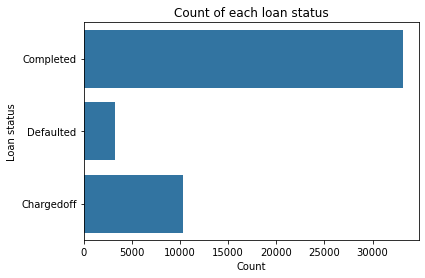

In [86]:
# plot distribution of LoanStatus

sns.countplot(data=loan_sub_data, y='LoanStatus', color=sns.color_palette()[0])
plt.xlabel('Count')
plt.ylabel('Loan status')
plt.title('Count of each loan status')
plt.show();

The above plot shows that most borrowers completed their loans.

##### What are the distributions of the employment status?

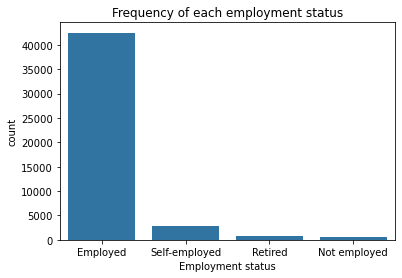

In [87]:
# distribution of employment status

ax = sns.countplot(data=loan_sub_data, x='EmploymentStatus', color=sns.color_palette()[0], 
        order=loan_sub_data.EmploymentStatus.value_counts().index)
ax.set(xlabel="Employment status",
        title="Frequency of each employment status")

plt.show();


From the plots, most borrowers are employed while the least of them are unemployed.

##### What are the distributions of the original loan amount, and the amount of principal as well as interests and fees paid by the borrowers?

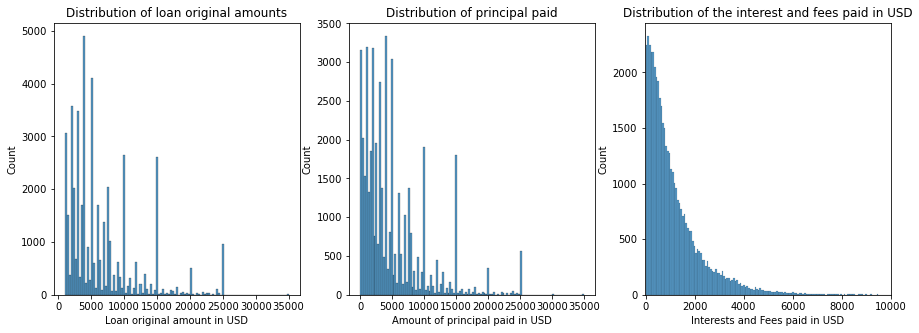

In [88]:
def get_bin_counts(series):
    """
       computes number of bins needed to plot the histogram of series
       using Freedman Diaconis algorithm if the IQR is not 0 else
       take the square root of the number of data points rounded up
       to the nearest integer
       
       :param series: quantitative pandas series
       :return integer: the number of bins
    """
    if series.quantile(0.75) - series.quantile(0.25) != 0:
        bin_width = 2*((series.quantile(0.75)-series.quantile(0.25))/(np.power(series.shape[0],1/3)))
        return ((series.max()-series.min())//bin_width).astype(int)
    return int(math.ceil(math.sqrt(series.shape[0])))

# distribution of the original loan amount

fig, axes = plt.subplots(1,3, figsize=(15,5))

ax1 = sns.histplot(data=loan_sub_data, x='LoanOriginalAmount', 
                  bins=get_bin_counts(loan_sub_data.LoanOriginalAmount), ax=axes[0])

ax1.set(xlabel='Loan original amount in USD',
        title='Distribution of loan original amounts')

# distribution of the amount of principal paid

ax2 = sns.histplot(data=loan_sub_data, x='LP_CustomerPrincipalPayments',
                   bins=get_bin_counts(loan_sub_data.LP_CustomerPayments), ax=axes[1])

ax2.set(xlabel='Amount of principal paid in USD',
        title='Distribution of principal paid')

# distribution of the interest and fees paid

ax3 = sns.histplot(data=loan_sub_data, x='LP_InterestandFees', 
               bins=get_bin_counts(loan_sub_data.LP_InterestandFees), ax=axes[2])

ax3.set_xlim(-50, 10000)

ax3.set(xlabel='Interests and Fees paid in USD',
        title='Distribution of the interest and fees paid in USD')

plt.show();

Both distributions are right skewed with several peaks. This shows that there is a relationship between the original loan amount and the principal paid by the borrowers which is expected. The distribution of the principal paid roughly shows a decrease in the amount paid with an increase in the number of borrowers. This trend is more clearly seen in the distribution of the interest and fees paid. Let's take a look at the distribution of the outstanding principal balance.

##### What is the distribution of the principal outstanding on the loans?



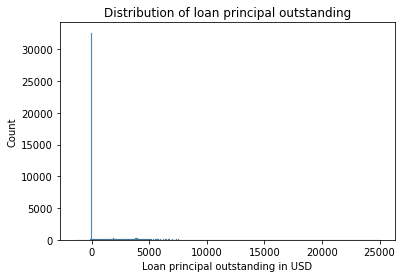

In [89]:
# we will create a new column LoanPrincipalOutstanding

loan_sub_data['LoanPrincipalOutstanding'] = loan_sub_data.LoanOriginalAmount - loan_sub_data.LP_CustomerPrincipalPayments

# We can now check out its distribution
sns.histplot(data=loan_sub_data, x='LoanPrincipalOutstanding',
            bins=get_bin_counts(loan_sub_data.LoanPrincipalOutstanding))

plt.xlabel('Loan principal outstanding in USD')
plt.title('Distribution of loan principal outstanding')

plt.show();

The plot doesn't look so good. Let's plot it on a log scale along the y-axis.

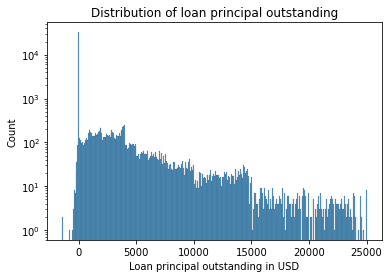

In [90]:
# distribution of the loan principal outstanding on a log scale along the y-axis

sns.histplot(data=loan_sub_data, x='LoanPrincipalOutstanding',
            bins=get_bin_counts(loan_sub_data.LoanPrincipalOutstanding))
            
plt.yscale('log')
plt.xlabel('Loan principal outstanding in USD')
plt.title('Distribution of loan principal outstanding')

plt.show();

The plot reveals some outliers before $0. Let's take a look at the value counts of our new variable.

In [91]:
loan_sub_data.LoanPrincipalOutstanding.value_counts(dropna=False).sort_index()

-1423.51     1
-1416.48     1
-837.66      1
-487.19      1
-454.00      1
            ..
 24528.77    1
 24548.25    1
 24597.90    1
 24740.46    1
 25000.00    8
Name: LoanPrincipalOutstanding, Length: 14180, dtype: int64

We can see that there are some negative principal outstandings which isn't quite right. Let's explore their original loan amounts and the amount of principal that has been paid. While we are at it, we will also explore their `LP_CustomerPayments` and `LP_InterestandFees` values.

In [92]:
loan_sub_data[loan_sub_data.LoanPrincipalOutstanding < 0][['LoanOriginalAmount', 'LP_CustomerPrincipalPayments',
                                                             'LP_CustomerPayments', 'LP_InterestandFees']]

,LoanOriginalAmount,LP_CustomerPrincipalPayments,LP_CustomerPayments,LP_InterestandFees
132,8600,8618.31,10373.47,1755.16
136,3000,3000.01,3985.53,985.52
156,5500,5500.01,7057.41,1557.40
197,3000,3000.01,3110.04,110.03
241,1100,1100.01,1793.46,693.45
...,...,...,...,...
113737,4500,4500.02,5158.67,658.65
113806,7500,7500.03,10053.24,2553.21
113818,10000,10007.34,11133.21,1125.87
113843,6001,6001.01,7406.21,1405.20


These are clearly outliers. The principal payments made by the borrowers can't be more than the loan original amount. The additional amounts on the principal payments must have come from the amounts paid for the interest and fees. We will therefore add the additional amounts to their corresponding `LP_InterestandFees` values.

In [93]:
# add excess principal payments to LP_InterestandFees

negative_principal_outstanding = loan_sub_data[loan_sub_data.LoanPrincipalOutstanding<0]
additional_interest_and_fees = negative_principal_outstanding.LoanPrincipalOutstanding * -1

to_replace = negative_principal_outstanding.LP_InterestandFees.values
values = to_replace + additional_interest_and_fees.values

loan_sub_data.LP_InterestandFees.replace(to_replace, values, inplace=True)

# set LP_CustomerPrincipalPayments of these records to be the same as LoanOriginalAmount

to_replace = negative_principal_outstanding.LP_CustomerPrincipalPayments.values
values = negative_principal_outstanding.LoanOriginalAmount.values

loan_sub_data.LP_CustomerPrincipalPayments.replace(to_replace, values, inplace=True)

loan_sub_data[loan_sub_data.LoanPrincipalOutstanding < 0][['LoanOriginalAmount', 'LP_CustomerPrincipalPayments',
                                                             'LP_CustomerPayments', 'LP_InterestandFees']]



,LoanOriginalAmount,LP_CustomerPrincipalPayments,LP_CustomerPayments,LP_InterestandFees
132,8600,8600.0,10373.47,1773.47
136,3000,3000.0,3985.53,985.53
156,5500,5500.0,7057.41,1557.41
197,3000,3000.0,3110.04,110.04
241,1100,1100.0,1793.46,693.46
...,...,...,...,...
113737,4500,4500.0,5158.67,658.67
113806,7500,7500.0,10053.24,2553.24
113818,10000,10000.0,11133.21,1133.21
113843,6001,6001.0,7406.21,1405.21


Now, we can replace all negative principal outstandings with 0.

In [94]:
to_replace = negative_principal_outstanding.LoanPrincipalOutstanding.values

loan_sub_data.LoanPrincipalOutstanding.replace(to_replace, 0, inplace=True)

loan_sub_data.LoanPrincipalOutstanding.value_counts()

0.00        26741
0.01         2737
0.01          660
0.02          444
0.02          386
            ...  
2099.76         1
6401.42         1
18263.01        1
2278.82         1
2176.51         1
Name: LoanPrincipalOutstanding, Length: 13433, dtype: int64

Let's now replot the distribution of the `LoanPrincipalOutstanding`, `LoanOriginalAmount`, `LP_CustomerPrincipalPayments`, and `LP_InterestandFees` variables.

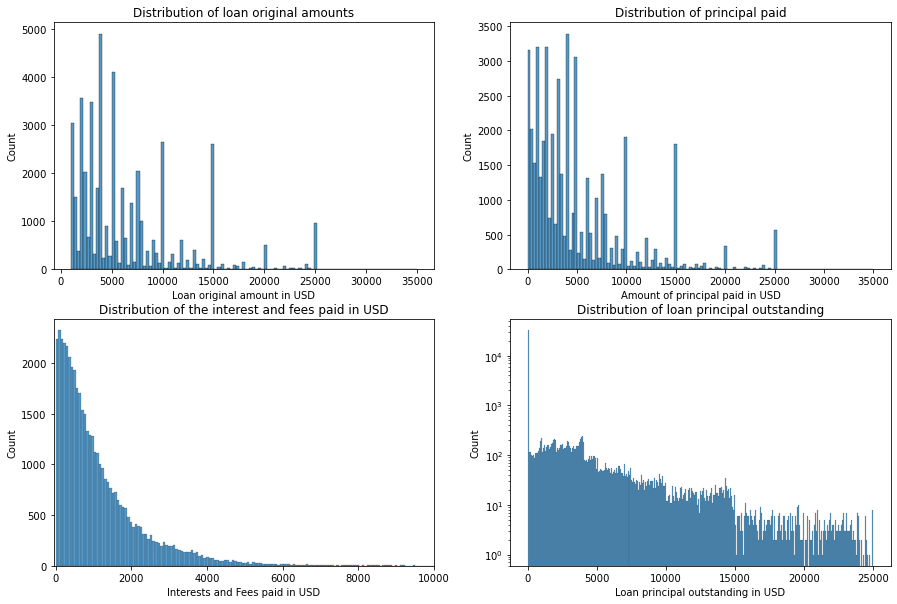

In [95]:
# distribution of the original loan amount

fig, axes = plt.subplots(2,2, figsize=(15,10))

ax1 = sns.histplot(data=loan_sub_data, x='LoanOriginalAmount', 
                  bins=get_bin_counts(loan_sub_data.LoanOriginalAmount), ax=axes[0][0])
                  
ax1.set(xlabel='Loan original amount in USD',
        title='Distribution of loan original amounts')

# distribution of the amount of principal paid

ax2 = sns.histplot(data=loan_sub_data, x='LP_CustomerPrincipalPayments',
                   bins=get_bin_counts(loan_sub_data.LP_CustomerPayments), ax=axes[0][1])

ax2.set(xlabel='Amount of principal paid in USD',
        title='Distribution of principal paid')

# distribution of the interest and fees paid

ax3 = sns.histplot(data=loan_sub_data, x='LP_InterestandFees', 
               bins=get_bin_counts(loan_sub_data.LP_InterestandFees), ax=axes[1][0])

ax3.set_xlim(-50, 10000)

ax3.set(xlabel='Interests and Fees paid in USD',
        title='Distribution of the interest and fees paid in USD')

# distribution of the loan principal outstanding on a log scale along the y-axis

ax4 = sns.histplot(data=loan_sub_data, x='LoanPrincipalOutstanding',
            bins=get_bin_counts(loan_sub_data.LoanPrincipalOutstanding), ax=axes[1][1])
            
ax4.set_yscale('log')
ax4.set_xlabel('Loan principal outstanding in USD')
ax4.set_title('Distribution of loan principal outstanding')

plt.show();

The distribution still looks the same, but with the negative principal outstanding outliers taken care of. The distribution of the loan principal outstanding shows that most borrowers have no principal outstanding which seems to agree with the bar plot of the loan status where we saw that most of the borrowers had completed their loan payments. This suggest a possible relationship between `LoanStatus` and `LoanPrincipalOutstanding`.

##### What is the distribution of the annual percentage rate?

As we can see, it is not significant. Therefore, it is okay to replace them with the mean value.

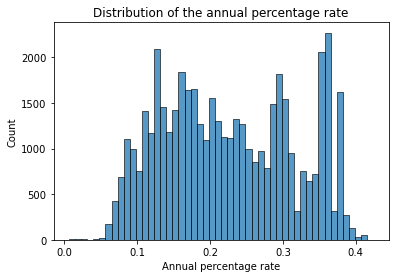

In [96]:
# distribution of the annual percentage rate.

ax = sns.histplot(data=loan_sub_data, x='BorrowerAPR', bins=get_bin_counts(loan_sub_data.BorrowerAPR))

ax.set(xlabel='Annual percentage rate',
        title='Distribution of the annual percentage rate')

plt.show();

From the plot, we can see that the distribution of the annual percentage rate is unimodal with the highest peak at around 0.37.

##### What are the distribuions of the total number of prior loans, loan term, and the listing categories?

`Term` and `ListingCategory (numeric)` are both categorical variables so we would explore their distribution on a bar plot. On the other hand, `TotalProsperLoans` is a discrete numeric variable, but because its range of values are relatively small, we can also explore its distribution with a bar plot. This variable also contains null values which means that the borrower had no prior prosper loan. We will replace them with 0.

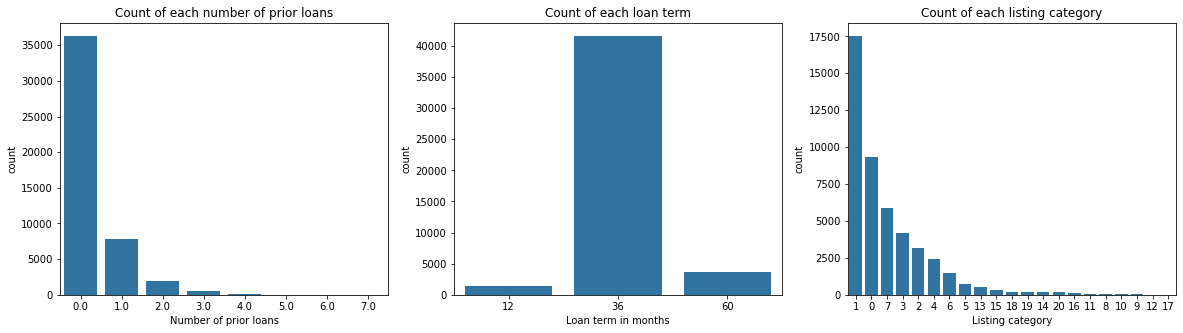

In [97]:
# Distribution of TotalProsperLoans

fig, axes = plt.subplots(1,3, figsize=(20,5))

loan_sub_data.TotalProsperLoans = loan_sub_data.TotalProsperLoans.fillna(0)

ax1 = sns.countplot(data=loan_sub_data, x='TotalProsperLoans', color=sns.color_palette()[0], ax=axes[0], 
                   order=loan_sub_data.TotalProsperLoans.value_counts().index)

ax1.set(xlabel="Number of prior loans",
        title="Count of each number of prior loans")

# distribution of Term

ax2 = sns.countplot(data=loan_sub_data, x='Term', color=sns.color_palette()[0], ax=axes[1])
ax2.set(xlabel="Loan term in months",
        title='Count of each loan term')

# distribution of ListingCategory

ax3 = sns.countplot(data=loan_sub_data, x='ListingCategory (numeric)', color=sns.color_palette()[0], ax=axes[2],
 order=loan_sub_data['ListingCategory (numeric)'].value_counts().index)

ax3.set(xlabel="Listing category",
        title="Count of each listing category")


plt.show();

From the plots, most borrowers had no prior Prosper loans. Also most of their loans were for a 3-year term, and most of them took loans for debt consolidation which is represented as 1 in the `ListCategory (numeric)` variable.

##### What is the distribution of number of days delinquent on the loan?

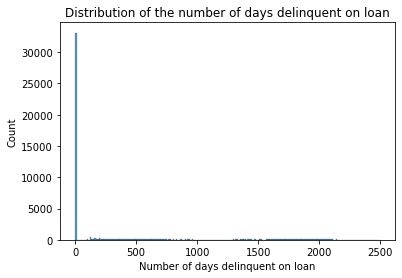

In [98]:
# distribution of LoanCurrentDaysDelinquent

sns.histplot(data=loan_sub_data, x='LoanCurrentDaysDelinquent', bins=get_bin_counts(loan_sub_data.LoanCurrentDaysDelinquent))

plt.xlabel('Number of days delinquent on loan')
plt.title('Distribution of the number of days delinquent on loan')

plt.show();

This doesn't look so good. Let's plot it on a log scale along the y-axis.

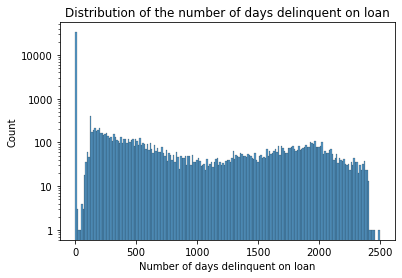

In [99]:
# distribution of LoanCurrentDaysDelinquent

ax = sns.histplot(data=loan_sub_data, x='LoanCurrentDaysDelinquent', 
                 bins=get_bin_counts(loan_sub_data.LoanCurrentDaysDelinquent))

ax.set_yscale('log')
ax.get_yaxis().set_major_formatter(ScalarFormatter())

ax.set_xlabel('Number of days delinquent on loan')
ax.set_title('Distribution of the number of days delinquent on loan')

plt.show();

The distribution is unimodal with the highest peak around 0. This shows that there are more borrowers who were not delinquent on their loans. This seems to agree with our earlier distribution plot of the `LoanStatus` variable where we noticed that most borrowers completed their loans. Therefore, there might be a relationship between both variables which we would explore in the bivariate section.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

Our univariate exploration of our variables of interest shows that most borrowers completed their loans and most of them where not delinquent which suggest a possible relationship between the `LoanStatus` and `LoanCurrentDaysDelinquent` variables. We had to plot the latter on a log scale along the y-axis due to its large range of frequencies in order to make its distribution more obvious. There might also be some relationship between the loan principal outstanding and the loan status because most of the borrowers have no principal outstandings.

Most of the borrowers had a 36-month loan term, and most of them didn't have any prior Prosper loan before applying for a loan. Furthermore, most of the borrowers took loans for debt consolidation. The `TotalProsperLoans` variable contains some null values which means that the borrower doesn't have any prior loans. We replaced them with 0 before ploting its distribution. Most borrowers are employed.

The distribution of the annual percentage rate is unimodal with the highest peak around 0.37. The `BorrowerAPR` variable has some missing values which wasn't accounted for in the data dictionary. Since the proportion of these values is not significant, I decided to replace them with the mean of the variable.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The plot of the loan principal outstanding revealed some negative outliers which was as a result of having principal payments which where greater than the original loan amount. After examining the `LP_InterestandFees` and `LP_CustomerPayments` values of records with this condition, I concluded that the excess principal payments might have been from interest and fee payments made by the borrower. So, I added them to their `LP_InterestandFees` values and replaced the affected `LP_CustomerPrincipalPayments` values with the values of their original loan amounts and the negative principal outstandings with 0.

## Bivariate Exploration

Let's begin the bivariate exploration, let's look at the pair wise correlation of our numeric features of interest.

In [32]:
numeric_vars = ['BorrowerAPR', 'LoanCurrentDaysDelinquent', 'LP_InterestandFees', 'TotalProsperLoans',
        'LoanOriginalAmount', 'LoanPrincipalOutstanding', 'LP_CustomerPrincipalPayments']

categorical_vars = ['Term', 'LoanStatus', 'EmploymentStatus', 'ListingCategory (numeric)']

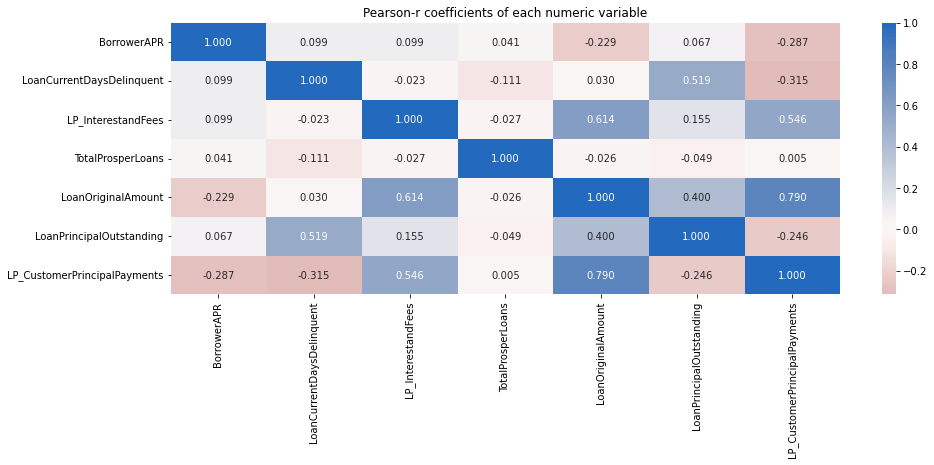

In [123]:
# we will explore the pairwise correlations with a heatmap

plt.figure(figsize=(15,5))
    
sns.heatmap(loan_sub_data[numeric_vars].corr(), annot=True, fmt='.3f', cmap='vlag_r', center=0)

plt.title("Pearson-r coefficients of each numeric variable")
plt.show();

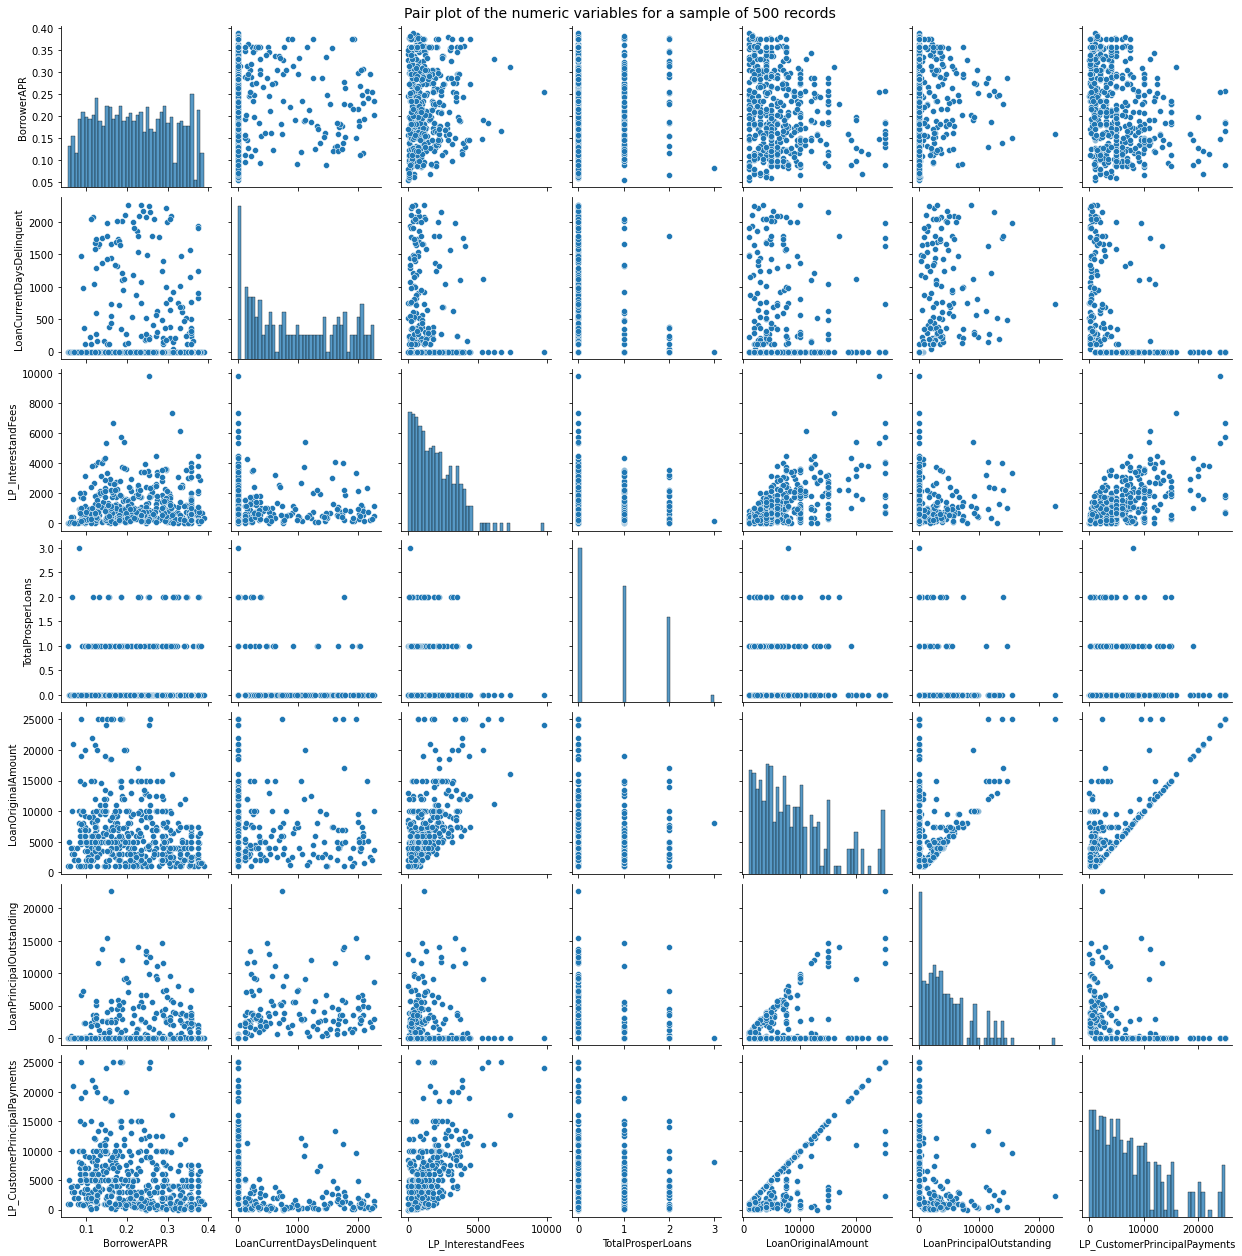

In [130]:
# plot matrix: sample 500 records so that the plots are clearer and render faster

sample = loan_sub_data.sample(n=500, replace=False)

g = sns.pairplot(data=sample, vars = numeric_vars, diag_kws={'bins': 40});
plt.yscale('log')
g.fig.suptitle("Pair plot of the numeric variables for a sample of 500 records", size=14, y=1.00);

As expected, there is a strong positive linear relationship between `LoanOriginalAmount` and `LP_CustomerPrincipalPayments` with some outliers. `LP_InterestandFees` also have a positive linear relationship with `LP_CustomerPrincipalPayments` but it is a bit weak. However, it has a moderately strong relationship with `LoanOriginalAmount`.

Let's see how `BorrowerAPR`, `LoanPrincipalOutstanding` and `LoanCurrentDaysDelinquent` correlates with the categorical variables.

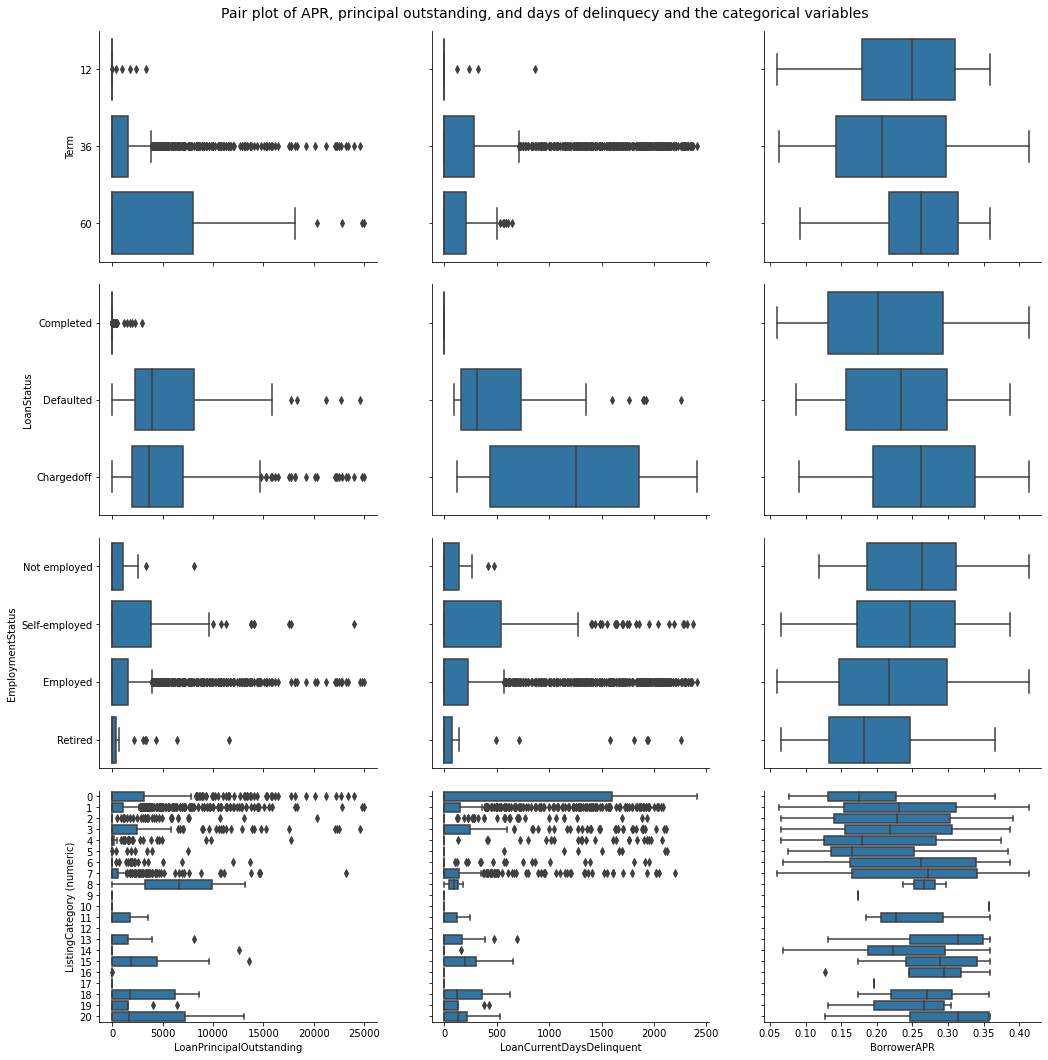

In [132]:

sample = loan_sub_data.sample(n=2000, replace=False)

g = sns.PairGrid(data=sample, x_vars=['LoanPrincipalOutstanding', 'LoanCurrentDaysDelinquent', 'BorrowerAPR'],
                y_vars=categorical_vars)

g.map(sns.boxplot,color=sns.color_palette()[0])
g.fig.set_size_inches(15,15);
g.fig.suptitle("Pair plot of APR, principal outstanding, and days of delinquecy and the categorical variables",
               size=14, y=1.00);

As suspected, there is a positive relationship between `LoanStatus` and `LoanCurrentDaysDelinquent`. There also seem to be a positive relationship between `LoanStatus` and `LoanPrincipalOutstanding` with the `Chargedoff` status having a slightly higher median compared to the `Defaulted` status. Furthermore, there is a positive relationship between `Term` and `LoanPrincipalOutstanding` with the 60-months term having more spread than the others.

We can also see a positive relationship between `BorrowerAPR` and `LoanStatus`. However, we also see a negative relationship between `BorrowerAPR` and `EmploymentStatus` which is quite interesting.

Finally, let's look at the relationship between the categorical variables.

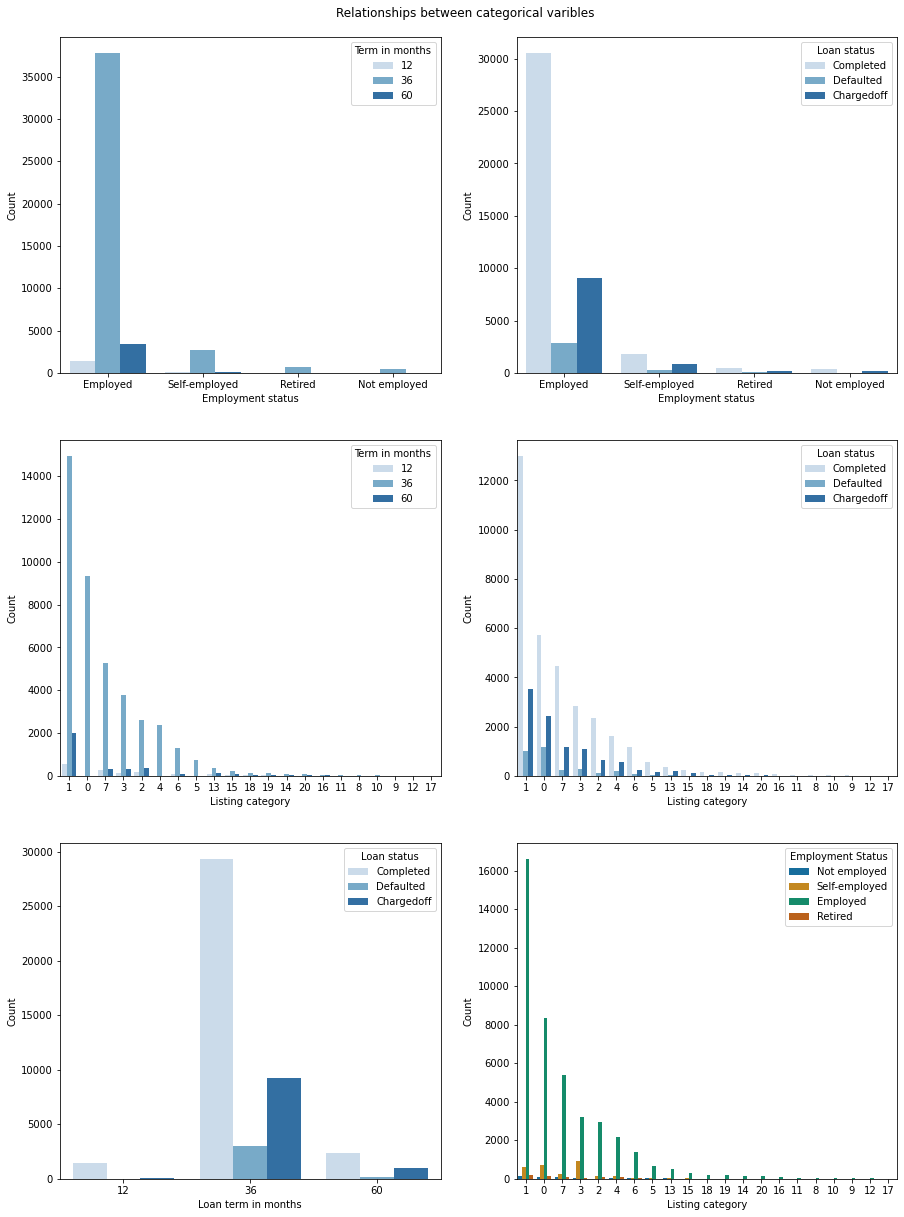

In [160]:
fig = plt.figure(figsize=(15,21))

fig.suptitle("Relationships between categorical varibles", y=0.90)

# EmploymentStatus versus Term
plt.subplot(3,2,1)
ax = sns.countplot(data=loan_sub_data, x='EmploymentStatus', hue='Term', 
                  order=loan_sub_data.EmploymentStatus.value_counts().index, palette='Blues')

ax.set_xlabel('Employment status')
ax.set_ylabel('Count')
ax.legend(title="Term in months")

# EmploymentStatus versus LoanStatus
plt.subplot(3,2,2)
ax = sns.countplot(data=loan_sub_data, x='EmploymentStatus', hue='LoanStatus',
                   order=loan_sub_data.EmploymentStatus.value_counts().index, palette='Blues')

ax.set_xlabel('Employment status')
ax.set_ylabel('Count')
ax.legend(title="Loan status")

# ListingCategory (numeric) versus Term
plt.subplot(3,2,3)
ax = sns.countplot(data=loan_sub_data, x= 'ListingCategory (numeric)', hue='Term', 
                  order=loan_sub_data['ListingCategory (numeric)'].value_counts().index, palette='Blues')

ax.set_xlabel('Listing category')
ax.set_ylabel('Count')
ax.legend(title="Term in months")

# ListingCategory (numeric) versus LoanStatus
plt.subplot(3,2,4)
ax = sns.countplot(data=loan_sub_data, x= 'ListingCategory (numeric)', hue='LoanStatus',
                   order=loan_sub_data['ListingCategory (numeric)'].value_counts().index, palette='Blues')

ax.set_xlabel('Listing category')
ax.set_ylabel('Count')
ax.legend(title='Loan status', loc='upper right')

# Term versus LoanStatus
plt.subplot(3,2,5)
ax = sns.countplot(data=loan_sub_data, x='Term', hue='LoanStatus', palette='Blues')

ax.set_xlabel('Loan term in months')
ax.set_ylabel('Count')
ax.legend(title='Loan status', loc='upper right')

# EmploymentStatus versus ListingCategory (numeric)
plt.subplot(3,2,6)
ax = sns.countplot(data=loan_sub_data, x='ListingCategory (numeric)', hue='EmploymentStatus',
                  order=loan_sub_data['ListingCategory (numeric)'].value_counts().index, palette='colorblind')

ax.set_xlabel('Listing category')
ax.set_ylabel('Count')
ax.legend(title='Employment Status', loc='upper right');


There don't seem to be any interaction between the employment status and term. On the other hand, there seem to be some interaction between employment and loan status. The gap between borrowers that were charged-off and those that completed their loans decrease when we consider the employment status of the borrowers. We can also see some interactions between loan status and loan term. The gap between borrowers that completed their loans and those that got charged-off seem to decrease as the loan term increases. Let's take a closer look at these interactions using a heatmap of their relative proportions.

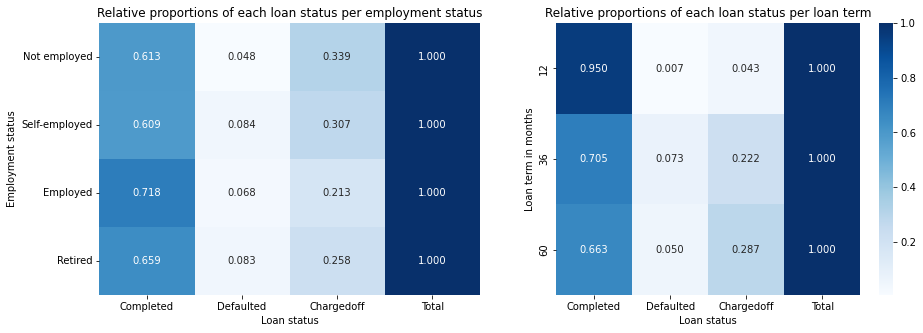

In [156]:
# contingency table of relative proportions of loan status for each loan term

def relative_proportion_ct(df, col_a, col_b):
    """
        returns the relative proportions of col_b grouped by col_a
        
        :params dataframe: the dataframe containing the data
        :params string: the name of the first column
        :params string: the name of the second column
        
        :returns dataframe: the relative proportion of the col_b grouped by col_a
    """
    ct = pd.crosstab(df[col_a], df[col_b])

    ct['Total'] = np.sum(ct, axis=1)
    for column in ct.columns:
        ct[column] = ct[column]/ct['Total']

    return ct

fig = plt.figure(figsize=(15,5))

# contingency table of relative proportions of LoanStatus per EmploymentStatus

data = relative_proportion_ct(loan_sub_data, 'EmploymentStatus', 'LoanStatus')

plt.subplot(1,2,1)
ax = sns.heatmap(data, annot=True, fmt='.3f', cmap='Blues', cbar=False)
ax.set_title('Relative proportions of each loan status per employment status')
ax.set_xlabel("Loan status")
ax.set_ylabel("Employment status")

# contingency table of relative proportions of LoanStatus per Term

data = relative_proportion_ct(loan_sub_data, 'Term', 'LoanStatus')

plt.subplot(1,2,2)
ax = sns.heatmap(data, annot=True, fmt='.3f', cmap='Blues')
ax.set_title('Relative proportions of each loan status per loan term')
ax.set_xlabel("Loan status")
ax.set_ylabel("Loan term in months")
plt.show();

The heatmap confirms our observation in both cases. The gap between the number of borrowers that completed their loans and those that were charged-off is shortest for those who are unemployed which suggests that a borrowers that fall in this category are more likely to have their loans charged-off compared to those who are self-employed, retired, or employed.

Similarly, we can see that the gap between those that completed their loans and those that where charged-off is shortest for borrowers that with a 5-year loan term which suggests that they are more likely to have their loans charged-off compared to those with the other loan terms.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

As we suspected in the univariate section, there is a positive relationship between the loan status and the number of delinquent days on payments which is expected. There is also a positive relationship betwen the loan status and the principal outstanding which also makes sense because the more the principal outstanding, the more likely for the borrower to either default or get charged-off. 

Another interesting relationship we observed is that between the loan status and the term. The gap between those that completed their loans and those that got charged-off decreases as the loan term increase. This suggests that borrowers with a 5-year loan term or more likely to get charged-off. We also see this trend in relationship between the employment and loan status. Those who are unemployed are more likely to have their loans charged-off as the gap between those that completed their loans and those that where charged-off is shortest of all the 4 employment status categories that we considered.

The relationship between the loan status and the annual percentage rate (APR) is also positive which suggests that the higher the APR the more likely for the borrowers to default or have their loans charged-off.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

We also observed some interesting relationships with the other features. We noticed that there is a positive relationship between the principal outstanding and the loan term. Another interesting relationship we observed is the negative relationship between the APR and the employment status. We will explore this further by investigating possible relationships between the APR, employment status, and loan status in the multi-variate section.

## Multivariate Exploration

##### Is there a correlation between the annual percentage rate, employment status, and loan status?

Let's investigate this using a facet of box plots.

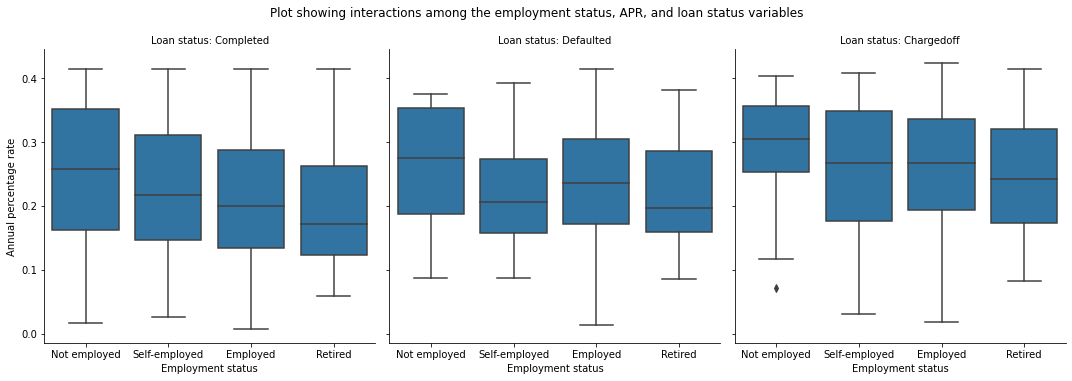

In [154]:
# facet grid of box plots to investigate
# the correlation between APR, employment status
# and loan status

g = sns.catplot(data=loan_sub_data, x='EmploymentStatus', y='BorrowerAPR', col='LoanStatus', 
            kind='box', color=sns.color_palette()[0]);

g.set_xlabels("Employment status")
g.set_ylabels("Annual percentage rate")
g.set_titles(template="Loan status: {col_name}")

g.fig.suptitle("Plot showing interactions among the employment status, APR, and loan status variables", y=1.05);

We can see a negative relationship which is more pronounced in the "Completed" and "Chargedoff" categories. There is generally a decrease in the annual percentage rate (APR) when we consider the "Not employed", "Self-employed", "Employed", and "Retired" categories in that order for each loan status. The only exception we can observe is the case where the median APR of self-employed borrowers is lesser than that of those who are employed where all the borrowers defaulted. Notice that the annual percentage rate is largest for borrowers whose loans were charged-off.

##### Is there a correlation between the Loan principal outstanding, term, and loan status?

Text(0.5, 1.05, 'Plot showing interactions among the term, principal outstanding, and loan status variables')

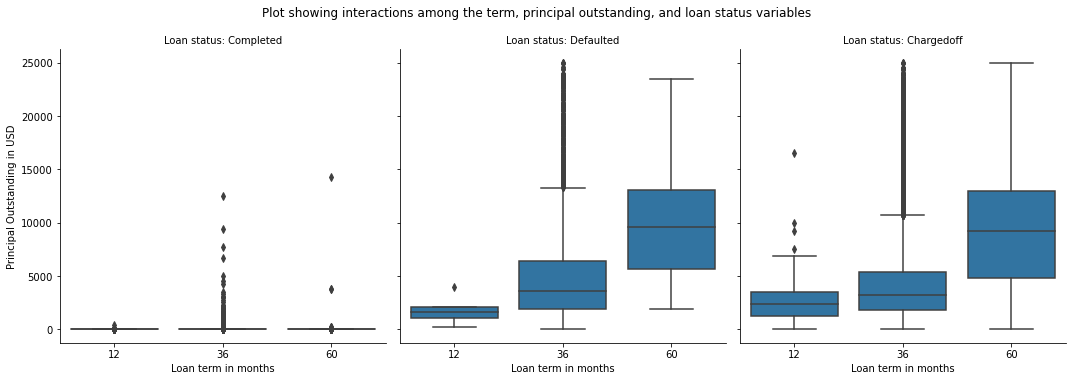

In [153]:
# facet grid of box plots to investigate
# the correlation between term, principal outstanding
# and loan status

g = sns.catplot(data=loan_sub_data, x='Term', y='LoanPrincipalOutstanding', col='LoanStatus', 
            kind='box', color=sns.color_palette()[0]);

g.set_xlabels("Loan term in months")
g.set_ylabels("Principal Outstanding in USD")
g.set_titles(template="Loan status: {col_name}")
            
g.fig.suptitle("Plot showing interactions among the term, principal outstanding, and loan status variables", y=1.05)

The plot shows a positive relationship between these variables with more outstandings with borrowers who either defaulted or got charged-off on their 5-year loan term compared to the other terms.

##### Is there a relationship between Principal outstanding, employment status, and loan status?

Text(0.5, 1.05, 'Plot showing interactions among the employment status, principal outstanding, and loan status variables')

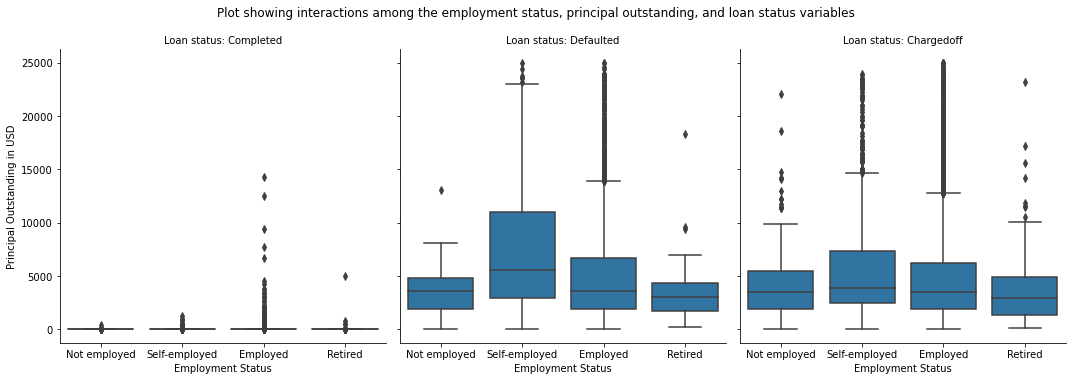

In [152]:
# facet grid of box plots to investigate
# the correlation between employment status, principal outstanding
# and loan status

g = sns.catplot(data=loan_sub_data, x='EmploymentStatus', y='LoanPrincipalOutstanding', col='LoanStatus', 
            kind='box', color=sns.color_palette()[0]);

g.set_xlabels("Employment Status")
g.set_ylabels("Principal Outstanding in USD")
g.set_titles(template="Loan status: {col_name}")

g.fig.suptitle("Plot showing interactions among the employment status, principal outstanding, and loan status variables"
               , y=1.05)

We can see a pattern here which implies that there is some interactions between these variables. We can see that borrowers who are self-employed that defaulted or have their loans charged-off have the largest median amount of principal outstandings compared to the others.

##### Is there a correlation between employment status, number of days delinquent, and the loan status?

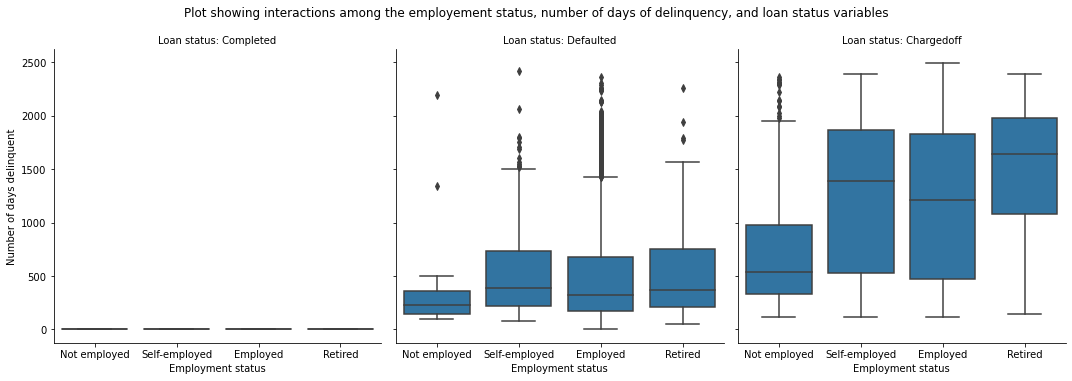

In [151]:
# facet grid of box plots to investigate
# the correlation between employment status, number of days of delinquency
# and loan status

g = sns.catplot(data=loan_sub_data, x='EmploymentStatus', y='LoanCurrentDaysDelinquent', col='LoanStatus', 
            kind='box', color=sns.color_palette()[0]);

g.set_xlabels("Employment status")
g.set_ylabels('Number of days delinquent')
g.set_titles(template="Loan status: {col_name}")

g.fig.suptitle("Plot showing interactions among the employement status, number of days of delinquency,"\
          + " and loan status variables", y=1.05);

The plot shows that there is a pattern which suggests some interactions among these variables. Borrowers who are retired and defaulted or have their loans charged-off have the highest number of days they were delinquent on their loans. We also observe that borrowers who are unemployed where delinquent for a lesser number of days before they where assigned the "Defaulted" or "Chargedoff" status. This might be because they are assumed to be more likely to be unable to complete their loans.

##### Is there a correlation between the employment status, the term, and the loan status?

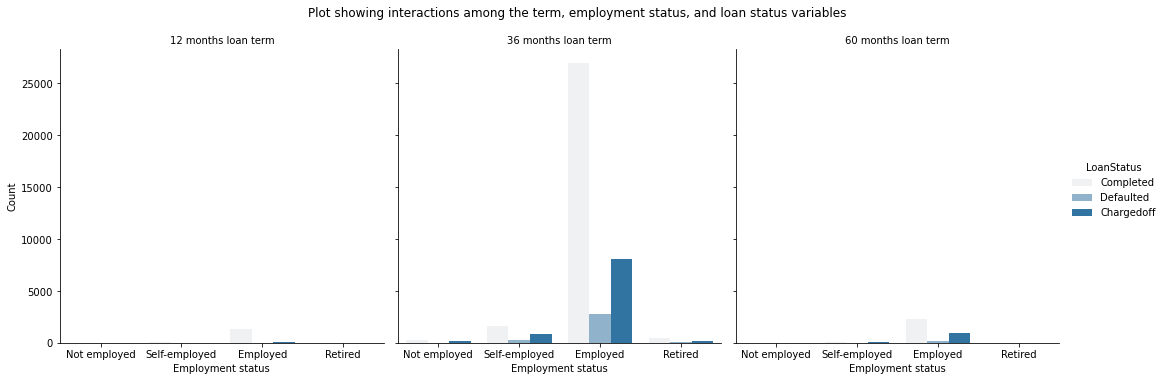

In [150]:
# facet grid of box plots to investigate
# the correlation between term, employment status
# and loan status

g = sns.catplot(data=loan_sub_data, x='EmploymentStatus', hue='LoanStatus', col='Term', 
            kind='count', color=sns.color_palette()[0]);

g.set_xlabels("Employment status")
g.set_ylabels("Count")
g.set_titles(template="{col_name} months loan term")

g.fig.suptitle("Plot showing interactions among the term, employment status, and loan status variables", y=1.05);

We can see some interactions here. To make it clearer, let's plot equal samples of records for each loan term.

Text(0.5, 1.05, 'Plot showing interactions among the term, employment status, and loan status variables')

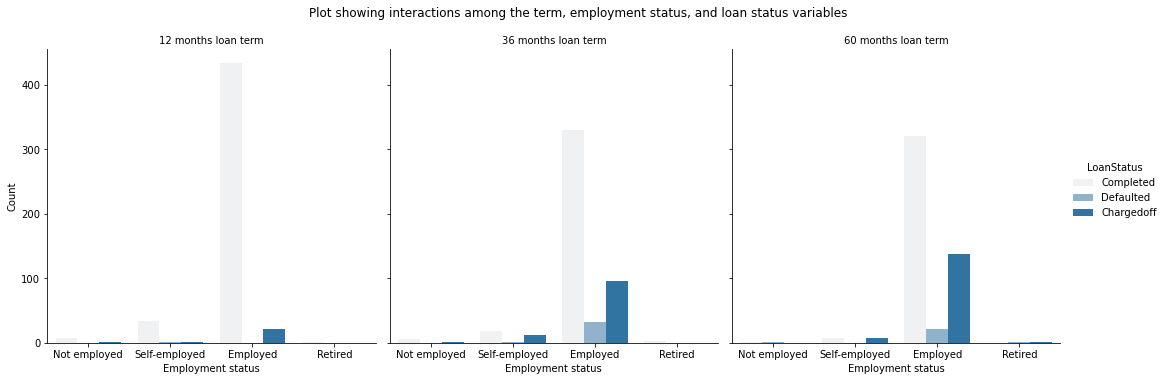

In [148]:
# We will plot equal samples of records with each loan term

one_year = loan_sub_data.query('Term==12').sample(500, replace=False)
three_years = loan_sub_data.query('Term==36').sample(500, replace=False)
five_years = loan_sub_data.query('Term == 60').sample(500, replace=False)

data = pd.concat([one_year, three_years, five_years], ignore_index=True)

g = sns.catplot(data=data, x='EmploymentStatus', hue='LoanStatus', col='Term', 
            kind='count', color=sns.color_palette()[0]);

g.set_xlabels("Employment status")
g.set_ylabels("Count")
g.set_titles(template="{col_name} months loan term")

g.fig.suptitle("Plot showing interactions among the term, employment status, and loan status variables", y=1.05)

We can see that the gap between those that completed their loans and those that where charged-off decreases as the loan term increases for each employment status.

##### How does loan status affect the relationship between the loan original amount, and the amount of principal paid?

Finally, let's take a closer look at the relationship between the principal amount that was paid by the borrowers and the original amount of the loan by categorizing each data point by their loan status.

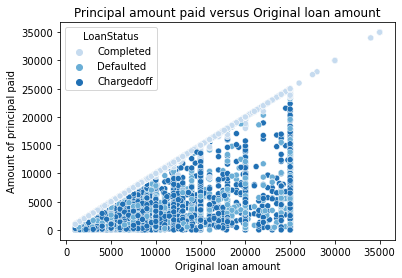

In [147]:
# relationship of the loan original amount and principal paid per loan status

sns.scatterplot(data=loan_sub_data, x='LoanOriginalAmount', y='LP_CustomerPrincipalPayments', 
               hue='LoanStatus', palette="Blues");

plt.xlabel("Original loan amount")
plt.ylabel("Amount of principal paid")

plt.title("Principal amount paid versus Original loan amount");

The plot shows that those who defaulted or have their loans charged-off form the area under the straight line (which comprises of data points belonging to borrowers that completed their loans) we saw in the scatter plot in the bivariate section. Because there are more borrowers who completed their loans, we observed a strong relationship between the original loan amount and the amount of principal that was paid. If there were fewer borrowers that completed their loans compared to those that defaulted or where charged-off, the strength of the relationship between `LoanStatus` and `LP_CustomerPrincipalPayments` may likely to decrease.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

From our investigation, we noticed a general negative relationshp between the employment status and APR for each loan status. The only exception we observed is in the case where the median APR of self-employed borrowers is lesser than those who where employed where all the borrowers defaulted. We also observed a positive relationship among the number of loan terms, loan status, and the principal outstanding which collaborates our earlier observations in the bivariate section that borrowers with more outstandings are more likely to either default or have their loans charged-off. The multivariate plot also reveals that borrowers that with a 5-year loan term tend to have the most outstandings. This is collaborated with the plot that examined the interactions between the employment status, loan term, and loan status. We see generally see a decrease in the gap between those that completed their loans and those whose loans where charged-off as the loan term increases for each employment status.

There is also some interactions between the employment status, loan status, and principal outstanding as well. Here, we observed that borrowers are retired and either defaulted or have their loans charged-off tend to have less outstandings. Interestingly, we noticed in the interactions between the employment status, loan status, and number of days of delinquency that borrowers who are unemployed and with either a "Defaulted" or "Chargedoff" status were generally delinquent for a lesser number of days compared to borrowers with other employment status. This seem to imply that these category of borrowers were declared to have defaulted or have their loans charged-off earlier than the others probably with the assumption that they are less likely to complete their payments.

Finally, we noticed that the strength of the relationship between the loan original amount and the amount of principal payments that were made which we observed in the bivariate section is largely influenced by the number of borrowers that completed their loans.

### Were there any interesting or surprising interactions between features?

I find the interaction between the employment status, loan status, and number of days of delinquency very interesting because it reveals that borrowers with an unemployed status are more likely to be given the "Defaulted" or "Chargedoff" after been delinquent for few days compared to those with other employement status. This could be because they are assumed to be less likely to complete their payments ones they are passed due.

## Conclusions

In conclusion, we see that the employment status, annual percentage rate, term of the loan, principal outstandings, and the number of days a borrower is delinquent are possible factors that can affect the loan outcome. 

This conclusion is made after considering only loans that have been closed (although cancelled loans are technically closed, they were not considered in this investigation), that is loans that were either completed, defaulted, or charged-off, and borrowers who where either unemployed, employed, self-employed, or retired. I had to merge borrowers with "Full-time" and "Part-time" status to those with a "Employed" status since it is safe to assume that they have an employer. Borrowers with "Other" and "Not available" status were not considered because it wasn't possible to determine their precise employment status. This is one of the limitations of this investigation.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

